YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


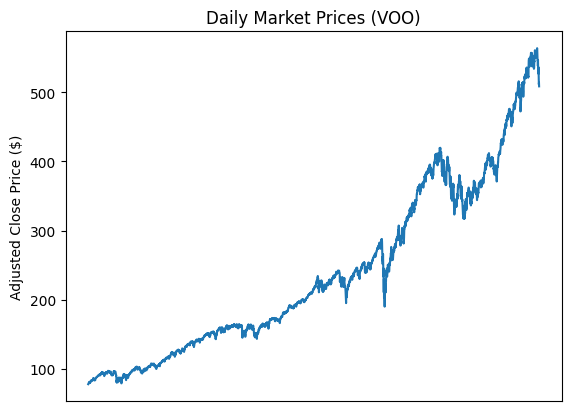

In [1]:
from lbm.datasets.security_prices import ClosePrices
from matplotlib import pyplot as plt

prices1 = ClosePrices('VOO', lookback=1)
train_loader, val_loader, test_loader = prices1.get_loaders()

plt.plot(prices1.df.to_numpy())
plt.title("Daily Market Prices (VOO)")
# turn off labels on x-axis
plt.ylabel("Adjusted Close Price ($)")
plt.xticks([])
plt.show()

In [2]:
from torch.optim import Adam
from torch.nn import MSELoss
from lbm.devices import get_device
from lbm.workflow.visualized import train_and_validate, ReturnDeltas, DirectionalAccuracy
import numpy as np
import torch
import warnings
from torch import nn

warnings.simplefilter('error')

device = get_device()

def validate_model(model, prices, epochs=50, optimizer=None, 
                   loss_fn=MSELoss(), device=device):
    if optimizer is None:
        optimizer = Adam(model.parameters())
    train_loader, val_loader, _ = prices.get_loaders()
    accuracy = DirectionalAccuracy()
    deltas = ReturnDeltas()
    metrics = [accuracy, deltas]
    train_and_validate(model, train_loader, val_loader, optimizer, loss_fn,
                       epochs=epochs, device=device, metrics=metrics)


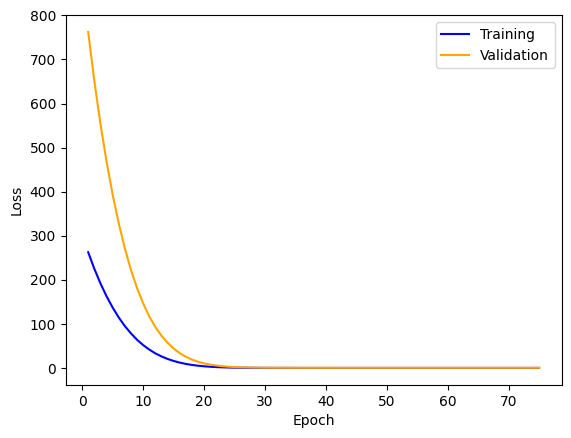

Directional Accuracy: 50.5%


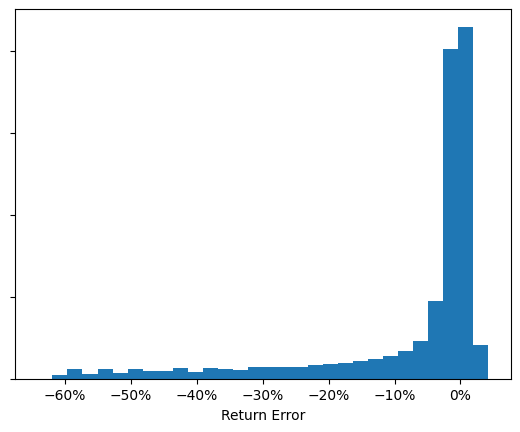

In [3]:
class LinearOneItemForecaster(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        x = x.squeeze(2)
        x = self.linear(x)
        x = x.unsqueeze(2)
        return x

model = LinearOneItemForecaster()

validate_model(model, prices1, epochs=75)

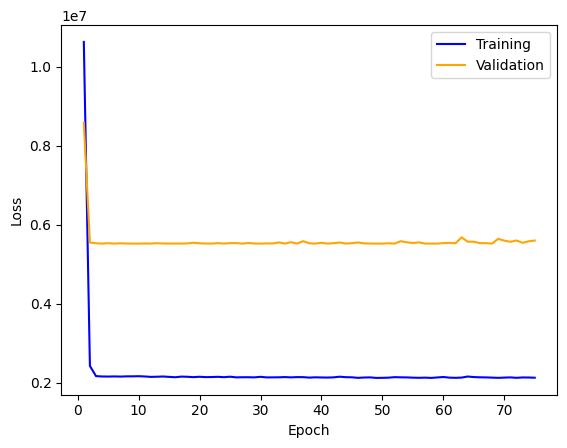

Directional Accuracy: 49.9%


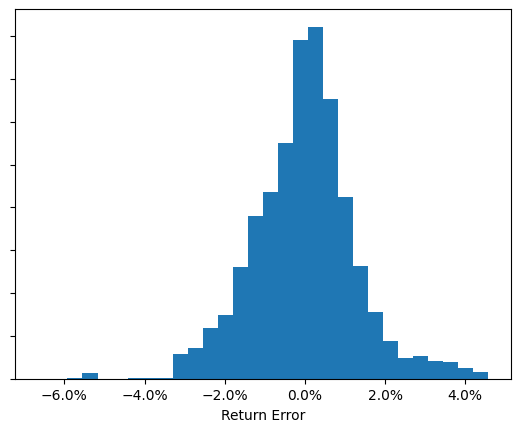

In [4]:
from lbm.loss import MASELoss

model = LinearOneItemForecaster()
loss = MASELoss()

validate_model(model, prices1, epochs=75, loss_fn=loss)

[*********************100%***********************]  1 of 1 completed


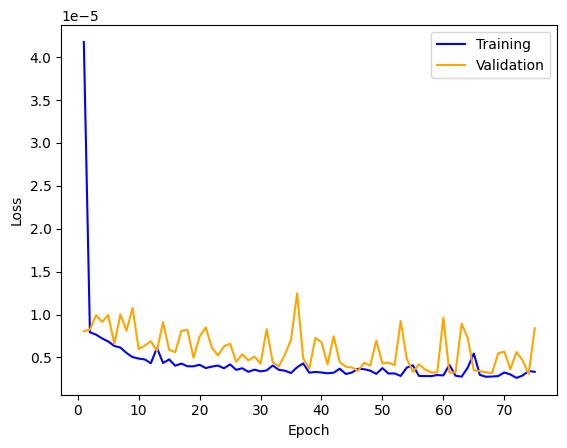

Directional Accuracy: 50.1%


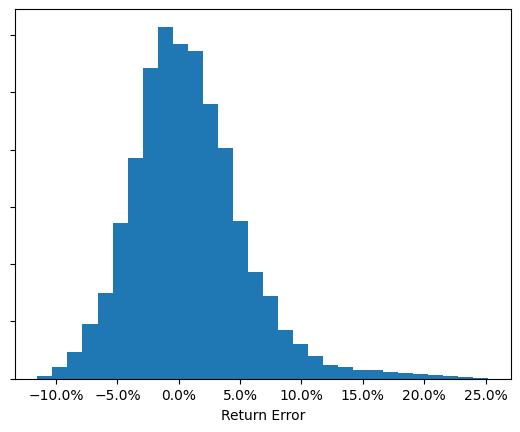

In [7]:
import torch.nn.functional as F

class FFN(torch.nn.Module):
    def __init__(self, lookback):
        super().__init__()
        self.layer_1 = nn.Linear(lookback, 64)
        self.layer_2 = nn.Linear(64, 32)
        self.layer_3 = nn.Linear(32, 32)
        self.layer_4 = nn.Linear(32, 1)

    def forward(self, x):
        x = x.squeeze(2)
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = F.relu(x)
        x = self.layer_3(x)
        x = F.relu(x)
        x = self.layer_4(x)
        x = x.unsqueeze(2)
        return x


lookback = 256
prices256 = ClosePrices('VOO', lookback=lookback)
train_loader, val_loader, test_loader = prices1.get_loaders()

model = FFN(lookback)
validate_model(model, prices256, epochs=75, loss_fn=loss)

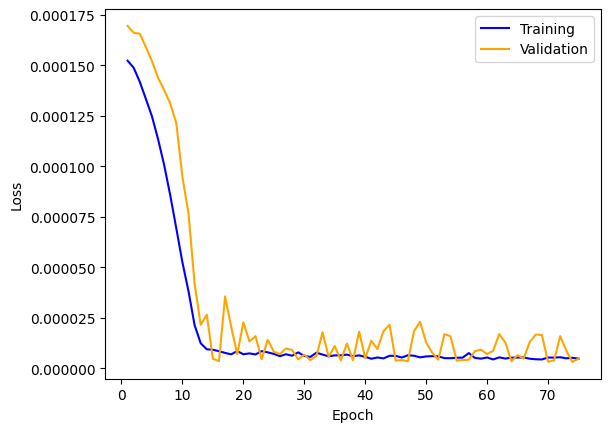

Directional Accuracy: 49.9%


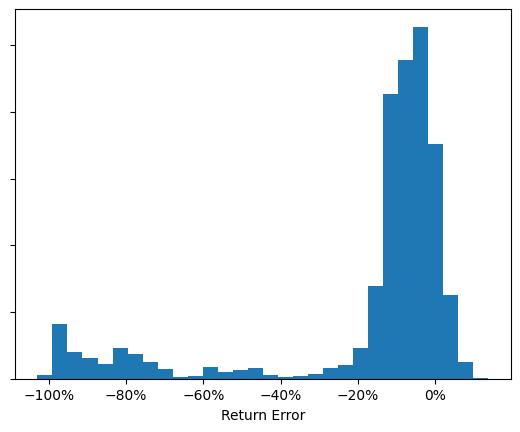

In [8]:
import torch.nn.functional as F

class FFN2(torch.nn.Module):
    def __init__(self, lookback):
        super().__init__()
        self.layer_1 = nn.Linear(lookback, 512)
        self.batch_norm_1 = nn.BatchNorm1d(512)
        self.layer_2 = nn.Linear(512, 256)
        self.batch_norm_2 = nn.BatchNorm1d(256)
        self.layer_3 = nn.Linear(256, 256)
        self.batch_norm_3 = nn.BatchNorm1d(256)
        self.layer_4 = nn.Linear(256, 1)

    def forward(self, x):
        x = x.squeeze(2)
        x = self.layer_1(x)
        x = self.batch_norm_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = self.batch_norm_2(x)
        x = F.relu(x)
        x = self.layer_3(x)
        x = self.batch_norm_3(x)
        x = F.relu(x)
        x = self.layer_4(x)
        x = x.unsqueeze(2)
        return x

model = FFN2(lookback)
validate_model(model, prices256, epochs=75, loss_fn=loss)

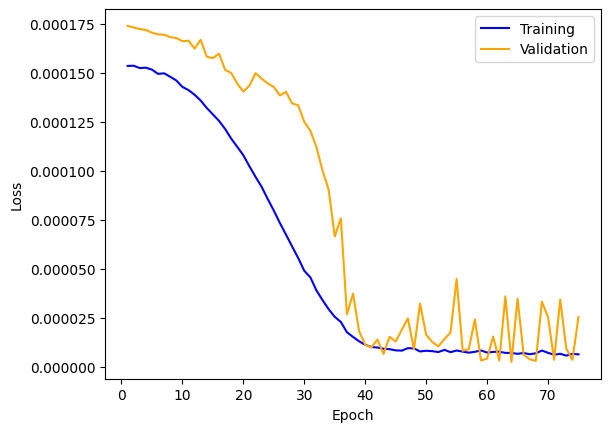

Directional Accuracy: 50.2%


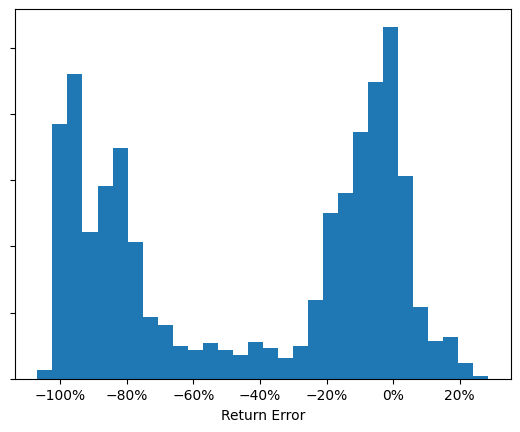

In [10]:
import torch.nn.functional as F

class DeepFFN(torch.nn.Module):
    def __init__(self, lookback):
        super().__init__()
        self.layer_1 = nn.Linear(lookback, 512)
        self.batch_norm_1 = nn.BatchNorm1d(512)
        self.layer_2 = nn.Linear(512, 256)
        self.batch_norm_2 = nn.BatchNorm1d(256)
        self.layer_3 = nn.Linear(256, 256)
        self.batch_norm_3 = nn.BatchNorm1d(256)
        self.layer_4 = nn.Linear(256, 128)
        self.batch_norm_4 = nn.BatchNorm1d(128)
        self.layer_5 = nn.Linear(128, 128)
        self.batch_norm_5 = nn.BatchNorm1d(128)
        self.layer_6 = nn.Linear(128, 64)
        self.batch_norm_6 = nn.BatchNorm1d(64)
        self.layer_7 = nn.Linear(64, 64)
        self.batch_norm_7 = nn.BatchNorm1d(64)
        self.layer_8 = nn.Linear(64, 32)
        self.batch_norm_8 = nn.BatchNorm1d(32)
        self.layer_9 = nn.Linear(32, 32)
        self.batch_norm_9 = nn.BatchNorm1d(32)
        self.layer_10 = nn.Linear(32, 1)

    def forward(self, x):
        x = x.squeeze(2)
        x = self.layer_1(x)
        x = self.batch_norm_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = self.batch_norm_2(x)
        x = F.relu(x)
        x = self.layer_3(x)
        x = self.batch_norm_3(x)
        x = F.relu(x)
        x = self.layer_4(x)
        x = self.batch_norm_4(x)
        x = F.relu(x)
        x = self.layer_5(x)
        x = self.batch_norm_5(x)
        x = F.relu(x)
        x = self.layer_6(x)
        x = self.batch_norm_6(x)
        x = F.relu(x)
        x = self.layer_7(x)
        x = self.batch_norm_7(x)
        x = F.relu(x)
        x = self.layer_8(x)
        x = self.batch_norm_8(x)
        x = F.relu(x)
        x = self.layer_9(x)
        x = self.batch_norm_9(x)
        x = F.relu(x)
        x = self.layer_10(x)
        x = x.unsqueeze(2)
        return x

model = DeepFFN(lookback)
validate_model(model, prices256, epochs=75, loss_fn=loss)

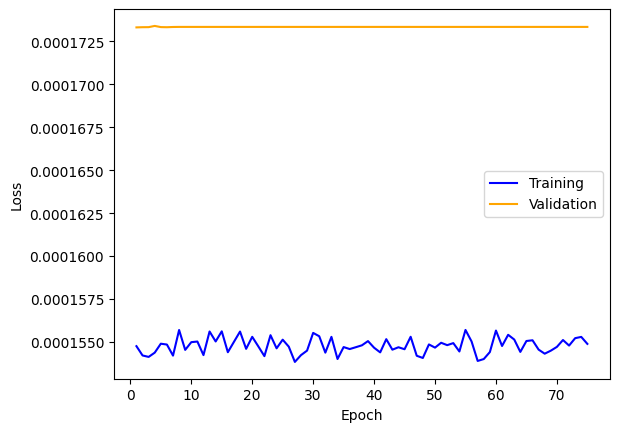

Directional Accuracy: 50.1%


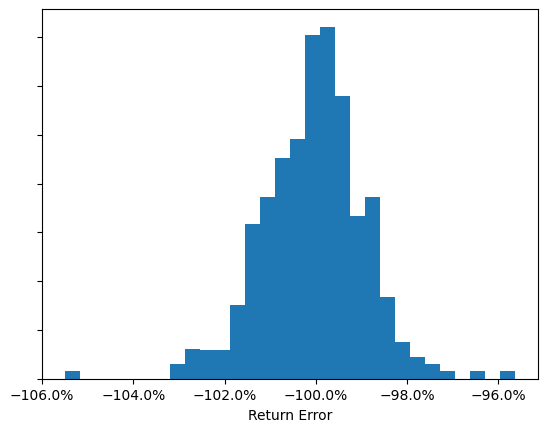

In [11]:
model = DeepFFN(lookback)
optim = Adam(model.parameters(), weight_decay=0.01)
validate_model(model, prices256, epochs=75, optimizer=optim, loss_fn=loss)

In [13]:
class RNNBased(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(1, 32, 5, batch_first=True)
        self.layer_1 = nn.Linear(32, 32)
        self.batch_norm = nn.BatchNorm1d(32)
        self.layer_2 = nn.Linear(32, 1)

    def forward(self, x):
        (_, h) = self.gru(x)
        x = h[-1]
        x = self.layer_1(x)
        x = self.batch_norm(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = x.unsqueeze(2)
        return x

model = RNNBased()
validate_model(model, prices256, epochs=75, loss_fn=loss, device='cpu')

KeyboardInterrupt: 

In [14]:
class RNN2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(1, 32, 5, batch_first=True)
        self.layer_1 = nn.Linear(32, 32)
        self.batch_norm = nn.BatchNorm1d(32)
        self.layer_2 = nn.Linear(32, 1)

    def forward(self, x):
        (_, h) = self.gru(x)
        x = h[-1]
        x = self.layer_1(x)
        x = self.batch_norm(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = x.unsqueeze(2)
        return x

model = RNN2()
validate_model(model, prices256, epochs=75, loss_fn=loss, device='cpu')

KeyboardInterrupt: 